# Chapter 4 - Classification

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.api.types import CategoricalDtype
from scipy import interpolate, stats
from sklearn import neighbors, preprocessing
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, auc, classification_report, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import classification

plt.style.use("seaborn-white")

In [2]:
%matplotlib inline

## 4.1 An Overview of Classification

In [3]:
df_default = pd.read_csv("Data/Default.csv")

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object.
df_default["is_default"] = df_default.default.factorize()[0]
df_default["is_student"] = df_default.student.factorize()[0]
df_default.head(3)

,default,student,balance,income,is_default,is_student
0,No,No,729.526495,44361.625074,0,0
1,No,Yes,817.180407,12106.134700,0,1
2,No,No,1073.549164,31767.138947,0,0


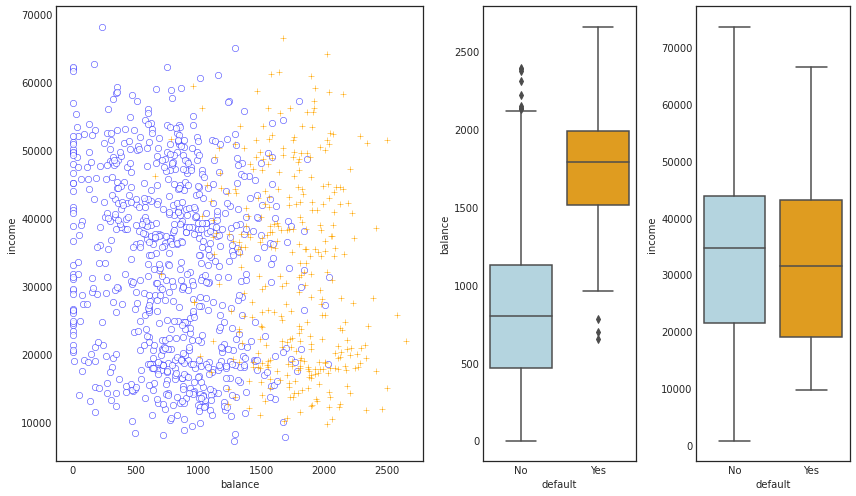

In [4]:
fig = plt.figure(figsize=(12, 7))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, :-2])
ax2 = plt.subplot(gs[0, -2])
ax3 = plt.subplot(gs[0, -1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df_default[df_default.is_default == 0].sample(frac=0.08)
# Take all samples  where target value is 'yes'
df_yes = df_default[df_default.is_default == 1]

sns.scatterplot(
    data=df_no,
    x="balance",
    y="income",
    s=40,
    marker="o",
    linewidths="1",
    edgecolor="blue",
    facecolors="white",
    alpha=0.8,
    ax=ax1,
)
sns.scatterplot(data=df_yes, x="balance", y="income", s=40, color="orange", marker="+", linewidths="1", ax=ax1)

c_palette = {"No": "lightblue", "Yes": "orange"}
sns.boxplot(x="default", y="balance", data=df_default, orient="v", ax=ax2, palette=c_palette)
sns.boxplot(x="default", y="income", data=df_default, orient="v", ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

## 4.2 Why Not Linear Regression?

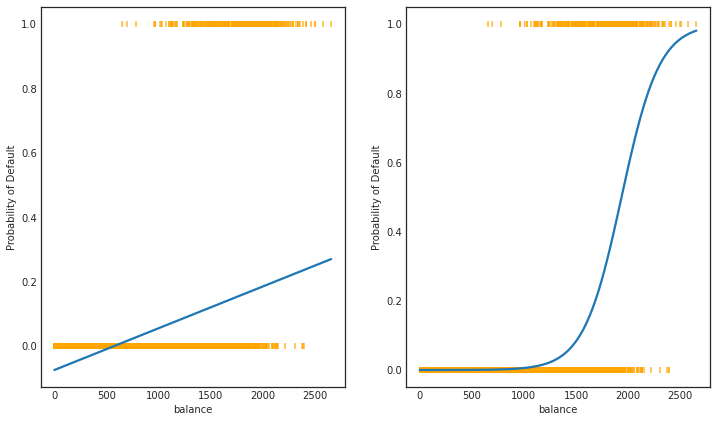

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

sns.regplot(data=df_default, x="balance", y="is_default", ax=ax1, ci=None, marker="|", scatter_kws=dict(color="orange"))
sns.regplot(
    data=df_default,
    x="balance",
    y="is_default",
    ax=ax2,
    logistic=True,
    ci=None,
    marker="|",
    scatter_kws=dict(color="orange"),
)
ax1.set_ylabel("Probability of Default")
ax2.set_ylabel("Probability of Default");

## 4.3 Logistic regression

In [6]:
est = smf.logit("is_default ~ balance", data=df_default).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [7]:
est = smf.logit("is_default ~ student", data=df_default).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student[T.Yes],0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


### 4.3.4 Multiple Logistic Regression

In [8]:
est = smf.logit("is_default ~ balance + income + student", data=df_default).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
student[T.Yes],-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019


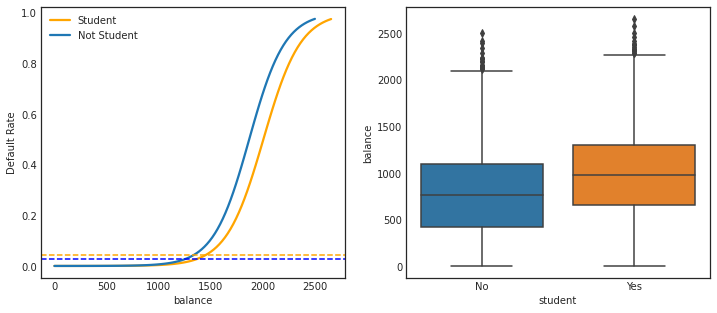

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.regplot(
    data=df_default[df_default.is_student == 1],
    x="balance",
    y="is_default",
    logistic=True,
    ci=None,
    scatter=False,
    color="orange",
    label="Student",
    ax=ax1,
)
sns.regplot(
    data=df_default[df_default.is_student == 0],
    x="balance",
    y="is_default",
    logistic=True,
    ci=None,
    scatter=False,
    label="Not Student",
    ax=ax1,
)
ax1.axhline(y=df_default[df_default.is_student == 1]["is_default"].mean(), linestyle="--", color="orange", markersize=0)
ax1.axhline(y=df_default[df_default.is_student == 0]["is_default"].mean(), linestyle="--", color="blue", markersize=0)
ax1.legend()
ax1.set_ylabel("Default Rate")

sns.boxplot(data=df_default, x="student", y="balance");

## 4.4 Generative Models for Classification

### 4.4.1 Linear Discriminant Analysis for p = 1

In [10]:
d1 = stats.norm(loc=-1.25, scale=1)
d2 = stats.norm(loc=1.25, scale=1)
xs = np.linspace(-5, 5, 1000)

d1_samples = d1.rvs(20)
d2_samples = d2.rvs(20)
mu_bayes = 0
mu_lda = (d1_samples.mean() + d2_samples.mean()) / 2

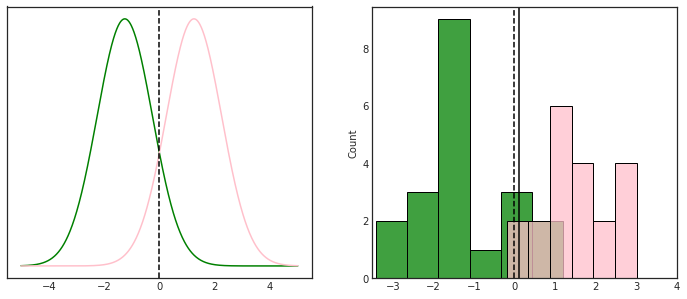

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(x=xs, y=d1.pdf(xs), color="green", ax=ax1)
sns.lineplot(x=xs, y=d2.pdf(xs), color="pink", ax=ax1)
ax1.axvline(x=mu_bayes, linestyle="--", color="black")
ax1.set_yticklabels([])

sns.histplot(x=d1_samples, color="green", ax=ax2)
sns.histplot(x=d2_samples, color="pink", ax=ax2)
ax2.axvline(x=mu_bayes, linestyle="--", color="black")
ax2.axvline(x=mu_lda, linestyle="-", color="black")
ax2.set_xlim(-3.5, 4);

In [12]:
d1_samples = d1.rvs(10000)
d2_samples = d2.rvs(10000)
mu_bayes = 0
mu_lda = (d1_samples.mean() + d2_samples.mean()) / 2

bayes_error_rate = (
    (len(d1_samples[d1_samples > mu_bayes]) + len(d2_samples[d2_samples < mu_bayes]))
    / (len(d1_samples) + len(d2_samples))
    * 100
)
lda_error_rate = (
    (len(d1_samples[d1_samples > mu_lda]) + len(d2_samples[d2_samples < mu_lda]))
    / (len(d1_samples) + len(d2_samples))
    * 100
)
print(f"The Bayes error rate is {bayes_error_rate:.2f}%, the LDA error rate is {lda_error_rate:.2f}%")

The Bayes error rate is 10.76%, the LDA error rate is 10.75%


### 4.4.2 Linear Discriminant Analysis for p >1

In [13]:
from mpl_toolkits import mplot3d

In [14]:
mu = np.array([0, 0])
cov1 = np.array([[1, 0], [0, 1]])
cov2 = np.array([[1, -0.7], [-0.7, 1]])

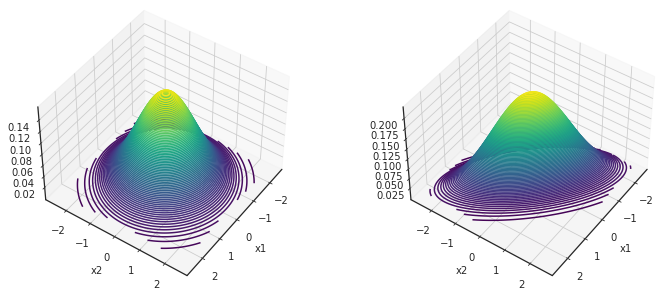

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), subplot_kw={"projection": "3d"})


def gaussian(x, y, mu, cov):
    return stats.multivariate_normal(mu, cov).pdf(np.stack((x, y), axis=2))


x = np.linspace(-2.4, 2.5, 100)
y = np.linspace(-2.5, 2.5, 100)

X, Y = np.meshgrid(x, y)
Z1 = gaussian(X, Y, mu, cov1)
Z2 = gaussian(X, Y, mu, cov2)

ax1.contour3D(X, Y, Z1, 100, cmap="viridis")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_zlabel("")
ax1.view_init(45, 35)

ax2.contour3D(X, Y, Z2, 100, cmap="viridis")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_zlabel("")
ax2.view_init(45, 35)

In [16]:
cov = np.array([[1, 0.4], [0.4, 1]])
mu1 = np.array([-1, -1])
mu2 = np.array([1, 2])
mu3 = np.array([2, 1])

In [17]:
# 95% confidence elipse
eigen_values, eigen_vectors = np.linalg.eig(cov)
lambda1, lambda2 = eigen_values

if lambda1 > lambda2:
    largest_eigen_vector = eigen_vectors[:, 0]
else:
    largest_eigen_vector = eigen_vectors[:, 1]
theta = np.arctan(largest_eigen_vector[1] / largest_eigen_vector[0]) * 180 / np.pi

chi2_critical_value = stats.chi2(df=2).ppf(0.95)
width = 2 * np.sqrt(chi2_critical_value * lambda1)
height = 2 * np.sqrt(chi2_critical_value * lambda2)

In [18]:
# grid of points to plot the bayes and LDA regions/lines
N_points_grid = 200
x_lines = np.linspace(-5, 5, 100 * N_points_grid)
xx, yy = np.meshgrid(np.linspace(-5, 5, N_points_grid), np.linspace(-5, 5, N_points_grid))
X = np.c_[xx.ravel(), yy.ravel()]

In [19]:
def bayes_regions_lda(mu1, mu2, mu3, cov, N, X, pi1=1, pi2=1, pi3=1):
    inv_cov = np.linalg.inv(cov)
    delta1_fun = lambda X: np.dot(X, np.dot(inv_cov, mu1)) - 1 / 2 * np.dot(mu1, np.dot(inv_cov, mu1)) + np.log(pi1)
    delta2_fun = lambda X: np.dot(X, np.dot(inv_cov, mu2)) - 1 / 2 * np.dot(mu2, np.dot(inv_cov, mu2)) + np.log(pi2)
    delta3_fun = lambda X: np.dot(X, np.dot(inv_cov, mu3)) - 1 / 2 * np.dot(mu3, np.dot(inv_cov, mu3)) + np.log(pi3)
    region1 = np.logical_and(delta1_fun(X) > delta2_fun(X), delta1_fun(X) > delta3_fun(X))
    region2 = np.logical_and(delta2_fun(X) > delta1_fun(X), delta2_fun(X) > delta3_fun(X))
    region3 = np.logical_and(delta3_fun(X) > delta1_fun(X), delta3_fun(X) > delta2_fun(X))

    return region1, region2, region3, delta1_fun, delta2_fun, delta3_fun

In [20]:
def bayes_lines_lda(mu1, mu2, mu3, cov, N, xs):
    inv_cov = np.linalg.inv(cov)
    x_coef_12, y_coef_12 = np.dot(inv_cov, mu1 - mu2)
    cte_coef_12 = -1 / 2 * np.dot(mu1 + mu2, np.dot(inv_cov, mu1 - mu2))

    x_coef_13, y_coef_13 = np.dot(inv_cov, mu1 - mu3)
    cte_coef_13 = -1 / 2 * np.dot(mu1 + mu3, np.dot(inv_cov, mu1 - mu3))

    x_coef_23, y_coef_23 = np.dot(inv_cov, mu2 - mu3)
    cte_coef_23 = -1 / 2 * np.dot(mu2 + mu3, np.dot(inv_cov, mu2 - mu3))

    # Bayes lines
    ys_12 = -(x_coef_12 * xs + cte_coef_12) / y_coef_12
    ys_13 = -(x_coef_13 * xs + cte_coef_13) / y_coef_13
    ys_23 = -(x_coef_23 * xs + cte_coef_23) / y_coef_23
    center_idx = np.argmin(np.abs(ys_12 - ys_13))

    return ys_12, ys_13, ys_23, center_idx

In [21]:
bayes_region1, bayes_region2, bayes_region3, bayes_delta1, bayes_delta2, bayes_delta3 = bayes_regions_lda(
    mu1, mu2, mu3, cov, N_points_grid, X
)
bayes_line_12, bayes_line_13, bayes_line_23, bayes_center_idx = bayes_lines_lda(
    mu1, mu2, mu3, cov, 100 * N_points_grid, x_lines
)

In [22]:
N_sample = 20
N_classes = 3
sample1 = stats.multivariate_normal(mean=mu1, cov=cov).rvs(N_sample)
sample2 = stats.multivariate_normal(mean=mu2, cov=cov).rvs(N_sample)
sample3 = stats.multivariate_normal(mean=mu3, cov=cov).rvs(N_sample)

# LDA prediction
pi1 = pi2 = pi3 = N_sample / N_classes  # priors
est_mu1 = 1 / N_sample * np.sum(sample1, axis=0)
est_mu2 = 1 / N_sample * np.sum(sample2, axis=0)
est_mu3 = 1 / N_sample * np.sum(sample3, axis=0)
est_cov = (np.cov(sample1, rowvar=False) + np.cov(sample2, rowvar=False) + np.cov(sample3, rowvar=False)) / N_classes

In [23]:
lda_region1, lda_region2, lda_region3, lda_delta1, lda_delta2, lda_delta3 = bayes_regions_lda(
    est_mu1, est_mu2, est_mu3, est_cov, N_points_grid, X, pi1, pi2, pi3
)
lda_line_12, lda_line_13, lda_line_23, lda_center_idx = bayes_lines_lda(
    est_mu1, est_mu2, est_mu3, est_cov, 100 * N_points_grid, x_lines
)

In [24]:
from matplotlib.patches import Ellipse

Bayes accuracy: 95.0%, 100.0%, 85.0%
LDA accuracy: 95.0%, 95.0%, 85.0%


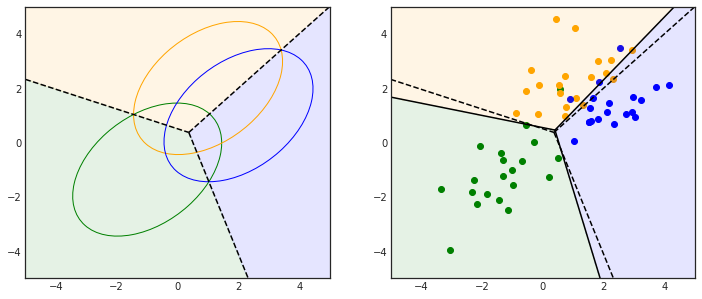

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

ellipse1 = Ellipse(mu1, width=width, height=height, angle=theta, facecolor="none", edgecolor="green")
ellipse2 = Ellipse(mu2, width=width, height=height, angle=theta, facecolor="none", edgecolor="orange")
ellipse3 = Ellipse(mu3, width=width, height=height, angle=theta, facecolor="none", edgecolor="blue")
ax1.add_patch(ellipse1)
ax1.add_patch(ellipse2)
ax1.add_patch(ellipse3)

# Bayes lines
ax1.plot(x_lines[:bayes_center_idx], bayes_line_12[:bayes_center_idx], "--", color="black")
ax1.plot(x_lines[bayes_center_idx:], bayes_line_13[bayes_center_idx:], "--", color="black")
ax1.plot(x_lines[bayes_center_idx:], bayes_line_23[bayes_center_idx:], "--", color="black")
# Bayes regions
ax1.contourf(xx, yy, bayes_region1.reshape(xx.shape), alpha=0.1, colors="green", levels=[0.5, 1.0])
ax1.contourf(xx, yy, bayes_region2.reshape(xx.shape), alpha=0.1, colors="orange", levels=[0.5, 1.0])
ax1.contourf(xx, yy, bayes_region3.reshape(xx.shape), alpha=0.1, colors="blue", levels=[0.5, 1.0])

ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)

# sample points
ax2.scatter(sample1[:, 0], sample1[:, 1], color="green")
ax2.scatter(sample2[:, 0], sample2[:, 1], color="orange")
ax2.scatter(sample3[:, 0], sample3[:, 1], color="blue")

# Bayes lines
ax2.plot(x_lines[:bayes_center_idx], bayes_line_12[:bayes_center_idx], "--", color="black")
ax2.plot(x_lines[bayes_center_idx:], bayes_line_13[bayes_center_idx:], "--", color="black")
ax2.plot(x_lines[bayes_center_idx:], bayes_line_23[bayes_center_idx:], "--", color="black")

# LDA lines
ax2.plot(x_lines[:lda_center_idx], lda_line_12[:lda_center_idx], "-", color="black")
ax2.plot(x_lines[lda_center_idx:], lda_line_13[lda_center_idx:], "-", color="black")
ax2.plot(x_lines[lda_center_idx:], lda_line_23[lda_center_idx:], "-", color="black")
# LDA regions
ax2.contourf(xx, yy, lda_region1.reshape(xx.shape), alpha=0.1, colors="green", levels=[0.5, 1.0])
ax2.contourf(xx, yy, lda_region2.reshape(xx.shape), alpha=0.1, colors="orange", levels=[0.5, 1.0])
ax2.contourf(xx, yy, lda_region3.reshape(xx.shape), alpha=0.1, colors="blue", levels=[0.5, 1.0])

ax2.set_xlim(-5, 5)
ax2.set_ylim(-5, 5)

pred_green = (
    sum([np.logical_and(bayes_delta1(x) > bayes_delta2(x), bayes_delta1(x) > bayes_delta3(x)) for x in sample1])
    / N_sample
    * 100
)
pred_orange = (
    sum([np.logical_and(bayes_delta2(x) > bayes_delta1(x), bayes_delta2(x) > bayes_delta3(x)) for x in sample2])
    / N_sample
    * 100
)
pred_blue = (
    sum([np.logical_and(bayes_delta3(x) > bayes_delta2(x), bayes_delta3(x) > bayes_delta1(x)) for x in sample3])
    / N_sample
    * 100
)
print(f"Bayes accuracy: {pred_green:.1f}%, {pred_orange:.1f}%, {pred_blue:.1f}%")
est_pred_green = (
    sum([np.logical_and(lda_delta1(x) > lda_delta2(x), lda_delta1(x) > lda_delta3(x)) for x in sample1])
    / N_sample
    * 100
)
est_pred_orange = (
    sum([np.logical_and(lda_delta2(x) > lda_delta1(x), lda_delta2(x) > lda_delta3(x)) for x in sample2])
    / N_sample
    * 100
)
est_pred_blue = (
    sum([np.logical_and(lda_delta3(x) > lda_delta1(x), lda_delta3(x) > lda_delta2(x)) for x in sample3])
    / N_sample
    * 100
)
print(f"LDA accuracy: {est_pred_green:.1f}%, {est_pred_green:.1f}%, {est_pred_blue:.1f}%")

In [26]:
X = df_default[["balance", "income", "is_student"]].values
y = df_default.default.values

lda = LinearDiscriminantAnalysis(solver="svd").fit(X, y)

In [27]:
classification.get_confusion_matrix(lda, X, y, labels=["No", "Yes"])

Real            
                   No  Yes  Total
Predicted No     9645  254   9899
          Yes      22   79    101
          Total  9667  333  10000

In [28]:
classification.get_confusion_matrix(lda, X, y, labels=["No", "Yes"], norm="true").round(3)

Real             
                    No    Yes Total
Predicted No     0.998  0.763  1.76
          Yes    0.002  0.237  0.24
          Total  1.000  1.000  2.00

In [29]:
y_pred = lda.predict(X)
print(classification_report(y, y_pred, target_names=["No", "Yes"], digits=3))

              precision    recall  f1-score   support

          No      0.974     0.998     0.986      9667
         Yes      0.782     0.237     0.364       333

    accuracy                          0.972     10000
   macro avg      0.878     0.617     0.675     10000
weighted avg      0.968     0.972     0.965     10000



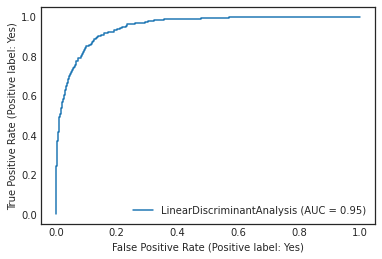

In [33]:
RocCurveDisplay.from_estimator(lda, X, y)

In [31]:
y_pred = lda.predict_proba(X)[:, 1] > 0.2
y_pred = np.array(["Yes" if y_i else "No" for y_i in y_pred])
classification.get_confusion_matrix(lda, X, y, labels=["No", "Yes"], y_pred=y_pred)

Real            
                   No  Yes  Total
Predicted No     9435  140   9575
          Yes     232  193    425
          Total  9667  333  10000

In [32]:
print(classification_report(y, y_pred, target_names=["No", "Yes"], digits=3))

              precision    recall  f1-score   support

          No      0.985     0.976     0.981      9667
         Yes      0.454     0.580     0.509       333

    accuracy                          0.963     10000
   macro avg      0.720     0.778     0.745     10000
weighted avg      0.968     0.963     0.965     10000



### 4.4.3 Quadratic Discriminant Analysis

In [34]:
mean1 = np.array([-1, -1])
mean2 = np.array([1, 1])
cov1 = np.array([[1, 0.4], [0.4, 1]])
cov2 = np.array([[1, 0.4], [0.4, 1]])
cov3 = np.array([[1, -0.4], [-0.4, 1]])

In [35]:
N = 500
K = 2
sample1 = np.random.multivariate_normal(mean1, cov1, (N,))
sample2 = np.random.multivariate_normal(mean2, cov2, (N,))

In [36]:
def bayes_regions_qda(mu1, mu2, cov1, cov2, N, X, pi1=1, pi2=1):
    inv_cov1 = np.linalg.inv(cov1)
    inv_cov2 = np.linalg.inv(cov2)
    delta1_fun = lambda Xin: -1 / 2 * ((Xin - mean1).dot(inv_cov1) * (Xin - mean1)).sum(axis=1) + np.log(pi1)
    delta2_fun = lambda Xin: -1 / 2 * ((Xin - mean2).dot(inv_cov2) * (Xin - mean2)).sum(axis=1) + np.log(pi2)
    region1 = delta1_fun(X) > delta2_fun(X)
    region2 = delta2_fun(X) > delta1_fun(X)

    return region1, region2, delta1_fun, delta2_fun

In [43]:
def plot_QDA(mean1, mean2, cov1, cov2, ax):

    # grid of points to plot the bayes and LDA regions/lines
    N_points_grid = 200
    xx, yy = np.meshgrid(np.linspace(-4, 4, N_points_grid), np.linspace(-4, 3, N_points_grid))
    X = np.c_[xx.ravel(), yy.ravel()]

    N = 100
    K = 2
    sample1 = np.random.multivariate_normal(mean1, cov1, (N,))
    sample2 = np.random.multivariate_normal(mean2, cov2, (N,))

    pi1 = pi2 = N / K

    bayes_region1, bayes_region2, bayes_delta1, bayes_delta2 = bayes_regions_qda(
        mean1, mean2, cov1, cov2, N_points_grid, X, pi1, pi2
    )

    # prediction
    est_mean1 = 1 / N * np.sum(sample1, axis=0)
    est_mean2 = 1 / N * np.sum(sample2, axis=0)
    est_cov1 = np.cov(sample1, rowvar=False)
    est_cov2 = np.cov(sample2, rowvar=False)
    qda_region1, qda_region2, qda_delta1, qda_delta2 = bayes_regions_qda(
        est_mean1, est_mean2, est_cov1, est_cov2, N_points_grid, X, pi1, pi2
    )

    # Bayes regions
    ax.contourf(xx, yy, qda_region1.reshape(xx.shape), alpha=0.1, colors="orange", levels=[0.5, 1.0])
    ax.contourf(xx, yy, qda_region2.reshape(xx.shape), alpha=0.1, colors="blue", levels=[0.5, 1.0])

    # Samples
    ax.scatter(
        sample1[:, 0],
        sample1[:, 1],
        s=20,
        c="orange",
        marker="o",
    )
    ax.scatter(
        sample2[:, 0],
        sample2[:, 1],
        s=20,
        c="blue",
        marker="o",
    )
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")

    # lines
    ax.contour(xx, yy, qda_region1.reshape(xx.shape), alpha=0.5, colors="green")
    ax.contour(xx, yy, bayes_region1.reshape(xx.shape), alpha=0.5, colors="purple")

    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 3)

    pred_green = sum(bayes_delta1(sample1) > bayes_delta2(sample1)) / N * 100
    pred_orange = sum(bayes_delta2(sample2) > bayes_delta1(sample2)) / N * 100
    print("Bayes accuracy: ", np.round(pred_green, 1), np.round(pred_orange, 1))
    est_pred_green = sum(qda_delta1(sample1) > qda_delta2(sample1)) / N * 100
    est_pred_orange = sum(qda_delta2(sample2) > qda_delta1(sample2)) / N * 100
    print("QDA accuracy: ", np.round(est_pred_green, 1), np.round(est_pred_orange, 1))

Bayes accuracy:  89.0 83.0
QDA accuracy:  88.0 80.0
Bayes accuracy:  92.0 97.0
QDA accuracy:  92.0 99.0


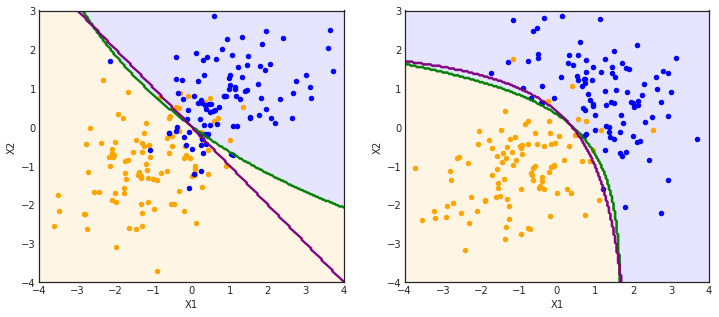

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
plot_QDA(mean1, mean2, cov1, cov2, ax=ax1)
plot_QDA(mean1, mean2, cov1, cov3, ax=ax2)

### 4.4.4 Naive Bayes

In [45]:
N = 1000
pi1 = pi2 = N / 2
d11 = stats.norm(loc=0, scale=0.8)
f11 = d11.rvs(N)
d21 = stats.norm(loc=-1.75, scale=0.75)
f21 = d21.rvs(N)

d12 = stats.norm(loc=2, scale=0.5)
f12 = d12.rvs(N)
d22 = stats.norm(loc=0, scale=1.25)
f22 = d22.rvs(N)

d13 = [0.2, 0.3, 0.5]
f13 = np.random.choice(a=[1, 2, 3], size=N, p=d13)
d23 = [0.6, 0.1, 0.3]
f23 = np.random.choice(a=[1, 2, 3], size=N, p=d23)

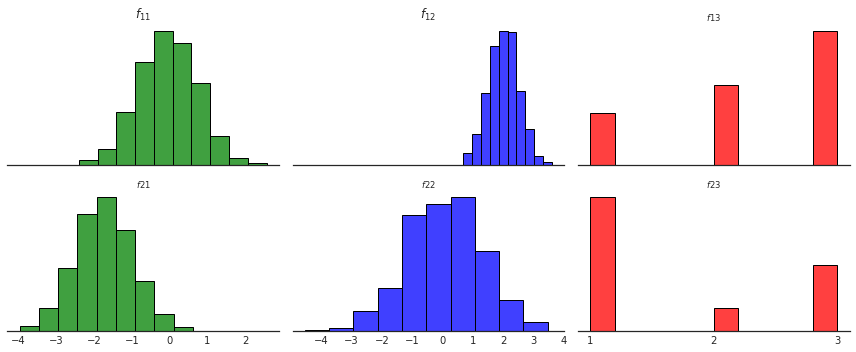

In [46]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 5), sharex="col")

colors = [
    "green",
    "blue",
    "red",
] * 2
labels = ["$f_{11}$", "$f_{12}$", "$_{f13}$", "$_{f21}$", "$_{f22}$", "$_{f23}$"]

for ax, f, color, label in zip(axs.flatten(), [f11, f12, f13, f21, f22, f23], colors, labels):
    sns.histplot(f, ax=ax, color=color, bins=10)
    ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(label)
    if color == "red":
        ax.set_xticks([1, 2, 3])
plt.tight_layout()

In [47]:
print(f"f11(0.4)={d11.pdf(0.4):.3f}, f12(1.5)={d12.pdf(1.5):.3f}, f13(1)={d13[0]:.3f}")
print(f"f21(0.4)={d21.pdf(0.4):.3f}, f22(1.5)={d22.pdf(1.5):.3f}, f23(1)={d23[0]:.3f}")

f11(0.4)=0.440, f12(1.5)=0.484, f13(1)=0.200
f21(0.4)=0.009, f22(1.5)=0.155, f23(1)=0.600


In [48]:
def naive_bayes(k, x, pis, fs):
    factor_1 = pis[0] * fs[0][0].pdf(x[0]) * fs[0][1].pdf(x[1]) * fs[0][2][int(x[2] - 1)]
    factor_2 = pis[1] * fs[1][0].pdf(x[0]) * fs[1][1].pdf(x[1]) * fs[1][2][int(x[2] - 1)]
    if k == 1:
        return factor_1 / (factor_1 + factor_2)
    elif k == 2:
        return factor_2 / (factor_1 + factor_2)
    else:
        return None

In [49]:
x = np.array((0.4, 1.5, 1))
pis = np.array((pi1, pi2))
fs = [[d11, d12, d13], [d21, d22, d23]]

In [50]:
print(f"P(k=1, X=x) = {naive_bayes(1, x, pis, fs):.3f}")
print(f"P(k=2, X=x) = {naive_bayes(2, x, pis, fs):.3f}")

P(k=1, X=x) = 0.981
P(k=2, X=x) = 0.019


In [51]:
X = df_default[["balance", "income", "is_student"]].values
y = df_default.default.values

gnb = GaussianNB().fit(X, y)

In [52]:
classification.get_confusion_matrix(gnb, X, y, labels=["No", "Yes"])

Real            
                   No  Yes  Total
Predicted No     9620  246   9866
          Yes      47   87    134
          Total  9667  333  10000

In [53]:
y_pred = gnb.predict_proba(X)[:, 1] > 0.2
y_pred = np.array(["Yes" if y_i else "No" for y_i in y_pred])
classification.get_confusion_matrix(gnb, X, y, labels=["No", "Yes"], y_pred=y_pred)

Real            
                   No  Yes  Total
Predicted No     9338  128   9466
          Yes     329  205    534
          Total  9667  333  10000

## 4.5 A Comparison of Classification Methods

### 4.5.2 An Empirical Comparison

In [56]:
N_datasets = 100
scenarios_samples = []

# scenario 1
N_samples = 20
scenario1_sample0 = np.random.multivariate_normal([0, 0], cov=np.eye(2), size=(N_datasets, N_samples))
scenario1_sample0 = np.concatenate((scenario1_sample0, np.zeros((N_datasets, N_samples, 1))), axis=2)
scenario1_sample1 = np.random.multivariate_normal([1, 1], cov=np.eye(2), size=(N_datasets, N_samples))
scenario1_sample1 = np.concatenate((scenario1_sample1, np.ones((N_datasets, N_samples, 1))), axis=2)
scenarios_samples.append(np.concatenate((scenario1_sample0, scenario1_sample1), axis=1))

# scenario 2
N_samples = 20
cov = np.array([[1, -0.5], [-0.5, 1]])
scenario2_sample0 = np.random.multivariate_normal([0, 0], cov=cov, size=(N_datasets, N_samples))
scenario2_sample0 = np.concatenate((scenario2_sample0, np.zeros((N_datasets, N_samples, 1))), axis=2)
scenario2_sample1 = np.random.multivariate_normal([1, 1], cov=cov, size=(N_datasets, N_samples))
scenario2_sample1 = np.concatenate((scenario2_sample1, np.ones((N_datasets, N_samples, 1))), axis=2)
scenarios_samples.append(np.concatenate((scenario2_sample0, scenario2_sample1), axis=1))

# scenario 3
N_samples = 50
df = 2
cov = np.array([[1, -0.5], [-0.5, 1]])
scenario3_sample0 = (
    stats.multivariate_t(loc=[0, 0], shape=cov, df=df).rvs(N_datasets * N_samples).reshape(N_datasets, N_samples, -1)
)
scenario3_sample0 = np.concatenate((scenario3_sample0, np.zeros((N_datasets, N_samples, 1))), axis=2)
scenario3_sample1 = (
    stats.multivariate_t(loc=[1, 1], shape=cov, df=df).rvs(N_datasets * N_samples).reshape(N_datasets, N_samples, -1)
)
scenario3_sample1 = np.concatenate((scenario3_sample1, np.ones((N_datasets, N_samples, 1))), axis=2)
scenarios_samples.append(np.concatenate((scenario3_sample0, scenario3_sample1), axis=1))

# scenario 4
N_samples = 20
scenario4_sample0 = np.random.multivariate_normal(
    [0, 0], cov=np.array([[1, 0.5], [0.5, 1]]), size=(N_datasets, N_samples)
)
scenario4_sample0 = np.concatenate((scenario4_sample0, np.zeros((N_datasets, N_samples, 1))), axis=2)
scenario4_sample1 = np.random.multivariate_normal(
    [1, 1], cov=np.array([[1, -0.5], [-0.5, 1]]), size=(N_datasets, N_samples)
)
scenario4_sample1 = np.concatenate((scenario4_sample1, np.ones((N_datasets, N_samples, 1))), axis=2)
scenarios_samples.append(np.concatenate((scenario4_sample0, scenario4_sample1), axis=1))

# scenario 5
N_samples = 20
centers = N_samples // 2
X, y = make_blobs(
    n_samples=N_datasets * 2 * N_samples, centers=centers, cluster_std=0.5, n_features=2, center_box=(-3, 3)
)
y = (y > centers // 2).astype("int").reshape(N_datasets, 2 * N_samples, 1)
scenario5_sample = np.concatenate((X.reshape(N_datasets, 2 * N_samples, 2), y), axis=2)
scenarios_samples.append(scenario5_sample)

# scenario 6
N_samples = 6
scenario6_sample0 = np.random.multivariate_normal([0, 0], cov=np.eye(2), size=(N_datasets, N_samples))
scenario6_sample0 = np.concatenate((scenario6_sample0, np.zeros((N_datasets, N_samples, 1))), axis=2)
scenario6_sample1 = np.random.multivariate_normal([1, 1], cov=2 * np.eye(2), size=(N_datasets, N_samples))
scenario6_sample1 = np.concatenate((scenario6_sample1, np.ones((N_datasets, N_samples, 1))), axis=2)
scenarios_samples.append(np.concatenate((scenario6_sample0, scenario6_sample1), axis=1))

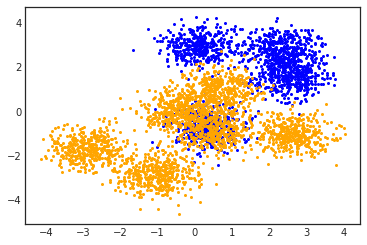

In [57]:
# plot scenario 5 non linear function
scenario5_sample_full = scenarios_samples[4]
scenario5_sample_full_one = scenario5_sample_full[scenario5_sample_full[:, :, 2] == 1]
scenario5_sample_full_zero = scenario5_sample_full[scenario5_sample_full[:, :, 2] == 0]
plt.scatter(x=scenario5_sample_full_one[:, 0], y=scenario5_sample_full_one[:, 1], c="blue", s=4)
plt.scatter(x=scenario5_sample_full_zero[:, 0], y=scenario5_sample_full_zero[:, 1], c="orange", s=4)

In [58]:
methods = ["knn_1", "knn_cv", "lda", "logistic", "gnb", "qda"]
colors_palette = {
    "knn_1": "deepskyblue",
    "knn_cv": "deepskyblue",
    "lda": "green",
    "logistic": "green",
    "gnb": "pink",
    "qda": "red",
}

In [59]:
scenario_scores = []
for num, scenario_samples in enumerate(scenarios_samples):
    print(f"Scenario {num+1}.")
    X_test = scenario_samples.reshape((-1, 3))[:, :-1]
    y_test = scenario_samples.reshape((-1, 3))[:, -1]
    for dataset in scenario_samples:
        X_train = dataset[:, :-1]
        y_train = dataset[:, -1]
        lda = LinearDiscriminantAnalysis(solver="svd").fit(X_train, y_train).score(X_test, y_test)
        qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train).score(X_test, y_test)
        gnb = GaussianNB().fit(X_train, y_train).score(X_test, y_test)
        logistic = LogisticRegression().fit(X_train, y_train).score(X_test, y_test)
        knn_1 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train).score(X_test, y_test)
        knn_cv = (
            GridSearchCV(KNeighborsClassifier(), {"n_neighbors": np.arange(1, 10)}, cv=5)
            .fit(X_train, y_train)
            .best_estimator_.score(X_test, y_test)
        )
        scenario_scores.append([num + 1, 1 - knn_1, 1 - knn_cv, 1 - lda, 1 - logistic, 1 - gnb, 1 - qda])

scenarios_scores = pd.DataFrame(scenario_scores, columns=["scenario", *methods])

Scenario 1.
Scenario 2.
Scenario 3.
Scenario 4.
Scenario 5.
Scenario 6.


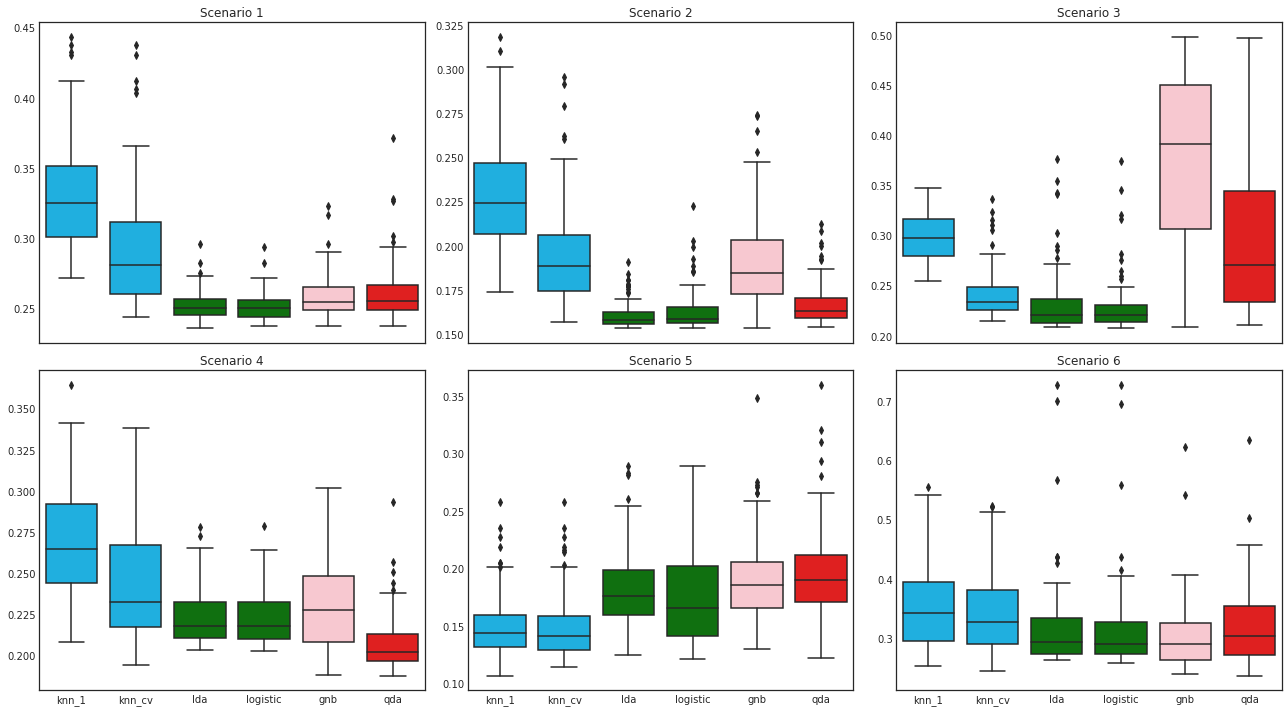

In [60]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(18, 10), sharex=True)

for num, ax in enumerate(axs.flatten()):
    data = scenarios_scores[scenarios_scores.scenario == num + 1].drop(columns="scenario")
    sns.boxplot(data=data, ax=ax, palette=colors_palette)
    ax.set_title(f"Scenario {num+1}")

plt.tight_layout()

## 4.6 Generalized Linear Models

In [61]:
df_bikeshare = pd.read_csv("Data/Bikeshare.csv", index_col=0)
month_type = CategoricalDtype(
    categories=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"], ordered=True
)
hr_type = CategoricalDtype(
    categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], ordered=True
)
df_bikeshare.mnth = df_bikeshare.mnth.astype(month_type)
df_bikeshare.hr = df_bikeshare.hr.astype(hr_type)
df_bikeshare.head(3)

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
1,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
2,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
3,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32


### 4.6.1 Linear Regression on the Bikeshare Data

In [62]:
bikeshare_ols = smf.ols("bikers ~ workingday + temp + C(weathersit) + C(mnth) + C(hr)", df_bikeshare).fit()
table = bikeshare_ols.summary().tables[1]
df = pd.DataFrame(table.data[1:], columns=["name", *table.data[0][1:]])
df["coef"] = df["coef"].astype("float")
df["clean_name"] = df["name"].str.replace(r"C\(.*\)\[T\.(.*)\]", "\g<1>", regex=True)
df[~df.name.str.contains("C\(mnth\)") & ~df.name.str.contains("C\(hr\)")]

,name,coef,std err,t,P>|t|,[0.025,0.975],clean_name
0,Intercept,-68.6317,5.307,-12.932,0.000,-79.035,-58.229,Intercept
1,C(weathersit)[T.cloudy/misty],-12.8903,1.964,-6.562,0.000,-16.741,-9.040,cloudy/misty
2,C(weathersit)[T.heavy rain/snow],-109.7446,76.667,-1.431,0.152,-260.031,40.542,heavy rain/snow
3,C(weathersit)[T.light rain/snow],-66.4944,2.965,-22.425,0.000,-72.307,-60.682,light rain/snow
38,workingday,1.2696,1.784,0.711,0.477,-2.228,4.768,workingday
39,temp,157.2094,10.261,15.321,0.000,137.095,177.324,temp


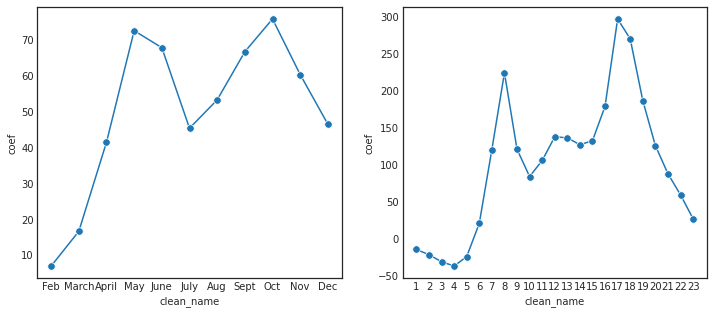

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.lineplot(data=df[df.name.str.contains(r"C\(mnth\)")], x="clean_name", y="coef", marker=".", markersize=15, ax=ax1)
sns.lineplot(data=df[df.name.str.contains(r"C\(hr\)")], x="clean_name", y="coef", marker=".", markersize=15, ax=ax2);

In [66]:
print(f"Number of negative predicted values: {(bikeshare_ols.fittedvalues < 0).mean():.1%}.")

Number of negative predicted values: 9.6%.


In [67]:
low_bikers = df_bikeshare[
    df_bikeshare.mnth.isin(["Dec", "Jan", "Feb"])
    & df_bikeshare.hr.isin([1, 2, 3, 4])
    & df_bikeshare.weathersit.isin(["light rain/snow", "heavy rain/snow"])
].bikers
high_bikers = df_bikeshare[
    df_bikeshare.mnth.isin(["April", "May", "Jun"])
    & df_bikeshare.hr.isin([7, 8, 9, 10])
    & (df_bikeshare.weathersit == "clear")
].bikers
print(f"At low times there are in average {low_bikers.mean():.2f} bikers, with a std. dev of {low_bikers.std():.2f}.")
print(
    f"At peak times there are in average {high_bikers.mean():.2f} bikers, with a std. dev of {high_bikers.std():.2f}."
)

At low times there are in average 4.54 bikers, with a std. dev of 3.60.
At peak times there are in average 212.07 bikers, with a std. dev of 116.47.


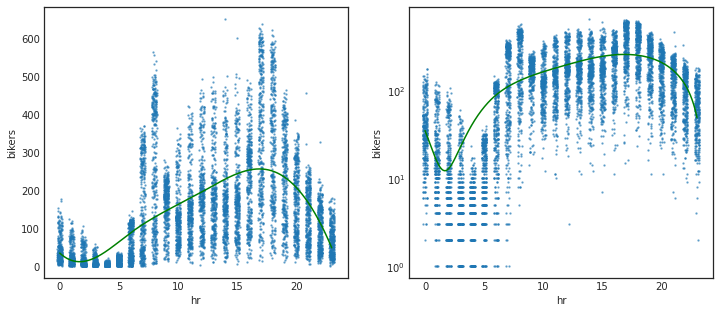

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

data = df_bikeshare[["hr", "bikers"]].copy().sort_values("hr").groupby(["hr"]).mean().reset_index()
spline = interpolate.UnivariateSpline(data.hr, data.bikers, s=50000)
xs = np.linspace(0, 23, 1000)
ys = spline(xs)
sns.regplot(
    data=df_bikeshare,
    x=df_bikeshare.hr.astype("int"),
    y="bikers",
    fit_reg=False,
    scatter_kws=dict(alpha=0.5, s=2),
    x_jitter=0.2,
    ax=ax1,
)
ax1.plot(xs, ys, c="g")

sns.regplot(
    data=df_bikeshare,
    x=df_bikeshare.hr.astype("int"),
    y="bikers",
    fit_reg=False,
    scatter_kws=dict(alpha=0.5, s=2),
    x_jitter=0.2,
    ax=ax2,
)
ax2.plot(xs, ys, c="g")
ax2.set_yscale("log")

### 4.6.2 Poisson Regression on the Bikeshare Data

In [69]:
bikeshare_poisson = smf.poisson("bikers ~ workingday + temp + C(weathersit) + C(mnth) + C(hr)", df_bikeshare).fit()
table = bikeshare_poisson.summary().tables[1]
df = pd.DataFrame(table.data[1:], columns=["name", *table.data[0][1:]])
df["coef"] = df["coef"].astype("float")
df["clean_name"] = df["name"].str.replace(r"C\(.*\)\[T\.(.*)\]", "\g<1>", regex=True)
df[~df.name.str.contains(r"C\(mnth\)") & ~df.name.str.contains("C\(hr\)")].round(3)

Optimization terminated successfully.
         Current function value: 16.256725
         Iterations 9


,name,coef,std err,z,P>|z|,[0.025,0.975],clean_name
0,Intercept,2.694,0.010,277.124,0.000,2.675,2.713,Intercept
1,C(weathersit)[T.cloudy/misty],-0.075,0.002,-34.528,0.000,-0.080,-0.071,cloudy/misty
2,C(weathersit)[T.heavy rain/snow],-0.926,0.167,-5.554,0.000,-1.253,-0.599,heavy rain/snow
3,C(weathersit)[T.light rain/snow],-0.576,0.004,-141.905,0.000,-0.584,-0.568,light rain/snow
38,workingday,0.015,0.002,7.502,0.000,0.011,0.018,workingday
39,temp,0.785,0.011,68.434,0.000,0.763,0.808,temp


<AxesSubplot:xlabel='clean_name', ylabel='coef'>

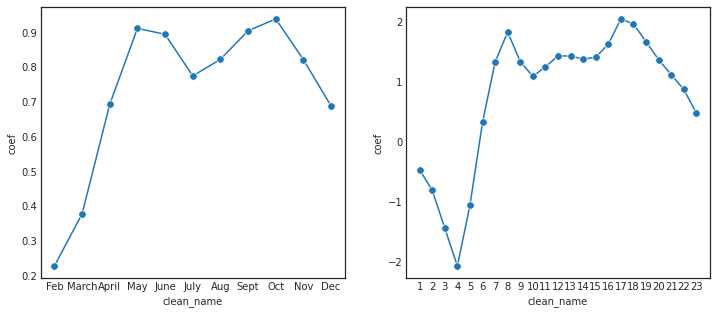

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.lineplot(data=df[df.name.str.contains(r"C\(mnth\)")], x="clean_name", y="coef", marker=".", markersize=15, ax=ax1)
sns.lineplot(data=df[df.name.str.contains(r"C\(hr\)")], x="clean_name", y="coef", marker=".", markersize=15, ax=ax2)

## 4.7 Lab: Classification Methods

### 4.7.1 The Stock Market Data

In [3]:
df_stock = pd.read_csv("Data/Smarket.csv", parse_dates=True)
# convert direction to binary. Up is 1, Down is 0
df_stock.replace({"Up": 1, "Down": 0}, inplace=True)
df_stock.Year = pd.to_datetime(df_stock.Year, format="%Y").dt.year.astype("str")
df_stock = df_stock.set_index("Year")
df_stock.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Year,,,,,,,,
2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,1
2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,1
2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,0
2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,1
2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,1


In [4]:
df_stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 2001 to 2005
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lag1       1250 non-null   float64
 1   Lag2       1250 non-null   float64
 2   Lag3       1250 non-null   float64
 3   Lag4       1250 non-null   float64
 4   Lag5       1250 non-null   float64
 5   Volume     1250 non-null   float64
 6   Today      1250 non-null   float64
 7   Direction  1250 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 87.9+ KB


In [5]:
df_stock.describe()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000
mean,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138,0.518400
std,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334,0.499861
min,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000,0.000000
25%,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500,0.000000
50%,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500,1.000000
75%,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750,1.000000
max,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000,1.000000


In [6]:
# very small correlations (today and direction are obiously correlated)
df_stock.corr().style.background_gradient("PiYG", axis=1)

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
Lag1,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155,-0.039757
Lag2,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250,-0.024081
Lag3,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448,0.006132
Lag4,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900,0.004215
Lag5,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860,0.005423
Volume,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592,0.022951
Today,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000,0.730563
Direction,-0.039757,-0.024081,0.006132,0.004215,0.005423,0.022951,0.730563,1.000000


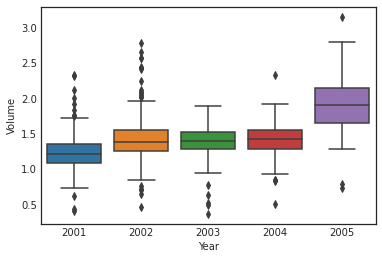

In [7]:
# volume increases with year
sns.boxplot(data=df_stock, x=df_stock.index, y="Volume");

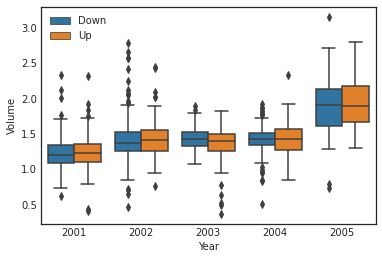

In [8]:
# volumne by year and direction
ax = sns.boxplot(data=df_stock, x=df_stock.index, y="Volume", hue="Direction")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Down", "Up"]);

#### Data for sklearn

In [41]:
X = df_stock[df_stock.columns.difference(["Today", "Direction"])]
y = df_stock["Direction"]

### 4.7.2 Logistic Regression

#### statsmodels

In [10]:
logistic = smf.logit("Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume", df_stock.reset_index()).fit()
logistic.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                0.002074
Time:                        17:44:35   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

In [14]:
log_predictions = logistic.predict()
log_predictions[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [38]:
y_pred = log_predictions > 0.5
y_pred_label = np.array(["Up" if y_i else "Down" for y_i in y_pred])
classification.get_confusion_matrix(
    logistic, X, y.map({1: "Up", 0: "Down"}), labels=["Up", "Down"], y_pred=y_pred_label
)

Real           
                  Up Down Total
Predicted Up     507  457   964
          Down   141  145   286
          Total  648  602  1250

In [40]:
(y == y_pred).mean()

0.5216

#### sklearn

No. Observations: 1250
Df Residuals: 1243
Df Model: 6
Log-Likelihood: -863.79
AIC: 1741.58
           Coefficients  Standard Errors  t values  p values
Intercept       -0.1260            0.050    -2.512     0.012
Lag1            -0.0731            0.050    -1.459     0.145
Lag2            -0.0423            0.050    -0.847     0.397
Lag3             0.0111            0.050     0.222     0.824
Lag4             0.0094            0.050     0.189     0.850
Lag5             0.0103            0.158     0.065     0.948
Volume           0.1354            0.241     0.563     0.574



Real           
                   0    1 Total
Predicted 0      145  141   286
          1      457  507   964
          Total  602  648  1250

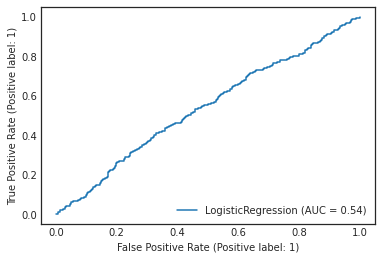

In [79]:
logistic = LogisticRegression(C=np.inf)
logistic.fit(X, y)
classification.print_OLS_error_table(logistic, X, y)
display(classification.get_confusion_matrix(logistic, X, y))
RocCurveDisplay.from_estimator(logistic, X, y);

#### test/train split

In [69]:
X_train = X[:"2004"]
y_train = y[:"2004"]
X_test = X["2005":]
y_test = y["2005":]

No. Observations: 998
Df Residuals: 991
Df Model: 6
Log-Likelihood: -690.55
AIC: 1395.11
           Coefficients  Standard Errors  t values  p values
Intercept        0.1912            0.052     3.692     0.000
Lag1            -0.0542            0.052    -1.046     0.296
Lag2            -0.0458            0.052    -0.887     0.375
Lag3             0.0072            0.052     0.139     0.889
Lag4             0.0064            0.051     0.126     0.900
Lag5            -0.0042            0.240    -0.018     0.986
Volume          -0.1163            0.334    -0.348     0.728



Real           
                   0    1 Total
Predicted 0       77   97   174
          1       34   44    78
          Total  111  141   252

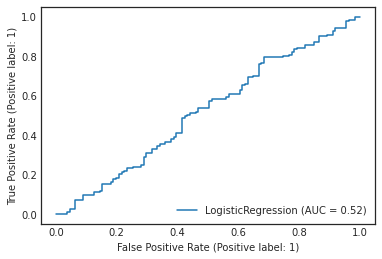

In [80]:
logistic_train = LogisticRegression(C=np.inf).fit(X_train, y_train)
classification.print_OLS_error_table(logistic_train, X_train, y_train)
display(classification.get_confusion_matrix(logistic_train, X_test, y_test))
RocCurveDisplay.from_estimator(logistic_train, X_test, y_test);

In [81]:
(y_test == logistic_train.predict(X_test)).mean()

0.4801587301587302

No. Observations: 998
Df Residuals: 995
Df Model: 2
Log-Likelihood: -690.70
AIC: 1387.40
           Coefficients  Standard Errors  t values  p values
Intercept        0.0322            0.052     0.623     0.533
Lag1            -0.0556            0.052    -1.076     0.282
Lag2            -0.0445            0.063    -0.702     0.483



Real           
                   0    1 Total
Predicted 0       35   35    70
          1       76  106   182
          Total  111  141   252

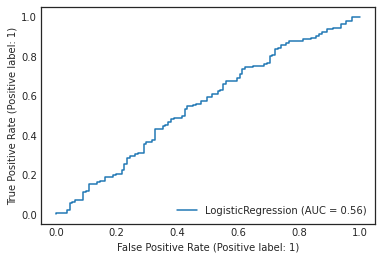

In [83]:
reduced_cols = ["Lag1", "Lag2"]
logistic_reduced = LogisticRegression(C=np.inf).fit(X_train[reduced_cols], y_train)
classification.print_OLS_error_table(logistic_reduced, X_train[reduced_cols], y_train)
display(classification.get_confusion_matrix(logistic_reduced, X_test[reduced_cols], y_test))
RocCurveDisplay.from_estimator(logistic_reduced, X_test[reduced_cols], y_test);

In [84]:
(y_test == logistic_reduced.predict(X_test[reduced_cols])).mean()

0.5595238095238095

In [92]:
logistic_reduced.predict_proba(pd.DataFrame([[1.2, 1.1], [1.5, -0.8]], columns=["Lag1", "Lag2"]))[:, 1]

array([0.47914604, 0.49611109])

### 4.7.3 Linear Discriminant Analysis

In [96]:
# use only Lag1 and Lag2
X_train_restricted = X_train[["Lag1", "Lag2"]]
X_test_restricted = X_test[["Lag1", "Lag2"]]

In [98]:
lda = LinearDiscriminantAnalysis().fit(X_train_restricted, y_train)
print("Prior probabilities of groups: ")
print(pd.DataFrame(data=lda.priors_.reshape((1, 2)), columns=["Down", "Up"], index=[""]))
print()
print("Group means: ")
print(pd.DataFrame(data=lda.means_, columns=X_train_restricted.columns, index=["Down", "Up"]))
print()
print("Coefficients of linear discriminant: ")
print(pd.DataFrame(data=lda.scalings_, columns=["LDA"], index=X_train_restricted.columns))
print()

Prior probabilities of groups: 
      Down        Up
  0.491984  0.508016

Group means: 
          Lag1      Lag2
Down  0.042790  0.033894
Up   -0.039546 -0.031325

Coefficients of linear discriminant: 
           LDA
Lag1 -0.642019
Lag2 -0.513529



Real           
                   0    1 Total
Predicted 0       35   35    70
          1       76  106   182
          Total  111  141   252

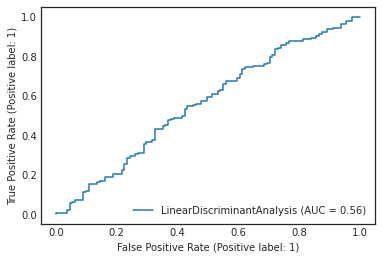

In [99]:
display(classification.get_confusion_matrix(lda, X_test_restricted, y_test))
RocCurveDisplay.from_estimator(lda, X_test_restricted, y_test);

In [108]:
importlib.reload(classification)

<module 'classification' from '/home/pedvide/ISLR_Python/classification.py'>

/home/pedvide/ISLR_Python/.venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


<AxesSubplot:xlabel='Lag1', ylabel='Lag2'>

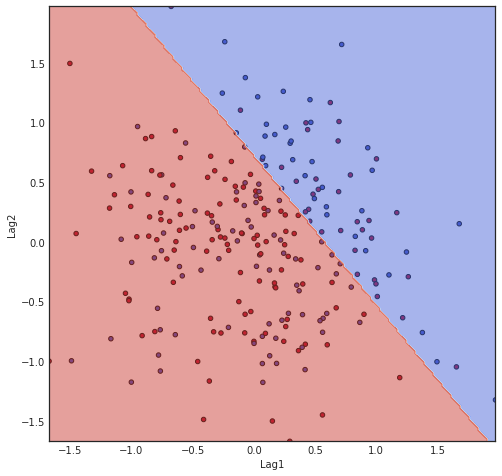

In [109]:
classification.plot_classification(lda, X_test_restricted, y_test)

## 4.6.4 Quadratic Discriminant Analysis (QDA)

In [26]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train2, y_train)
print("Prior probabilities of groups: ")
print(pd.DataFrame(data=qda.priors_.reshape((1, 2)), columns=["Down", "Up"], index=[""]))
print()
print("Group means: ")
print(pd.DataFrame(data=qda.means_, columns=X_train2.columns, index=["Down", "Up"]))
print()

Prior probabilities of groups: 
      Down        Up
  0.491984  0.508016

Group means: 
          Lag1      Lag2
Down  0.042790  0.033894
Up   -0.039546 -0.031325



Classification Report:
             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252

Confusion Matrix:
           Predicted          
                True     False
Real True   0.270270  0.729730
     False  0.141844  0.858156



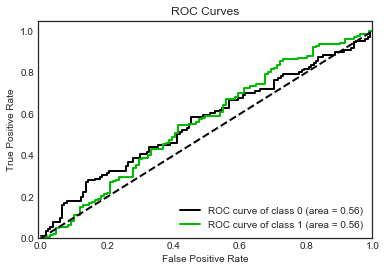

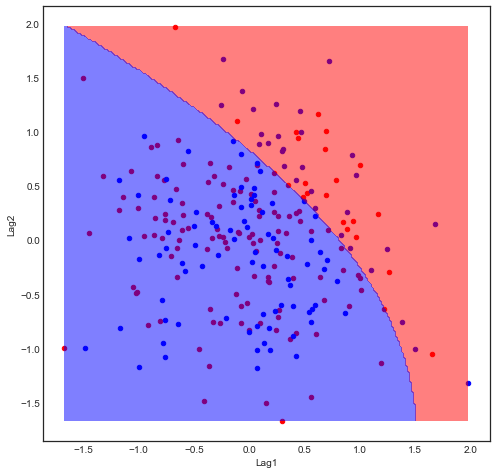

In [27]:
print_classification_statistics(qda, X_test2, y_test, labels=["Down", "Up"])
plot_ROC(qda, X_test2, y_test, label="QDA Train/Test, only Lag1 and Lag2")
plot_classification(qda, X_test2, y_test)

## 4.6.5 K-Nearest Neighbors

In [28]:
n_neighbors = 3
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train2, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Classification Report:
             precision    recall  f1-score   support

       Down      0.466     0.432     0.449       111
         Up      0.577     0.610     0.593       141

avg / total      0.528     0.532     0.529       252

Confusion Matrix:
           Predicted          
                True     False
Real True   0.432432  0.567568
     False  0.390071  0.609929



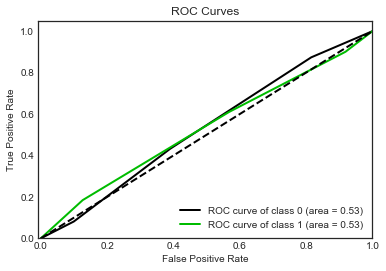

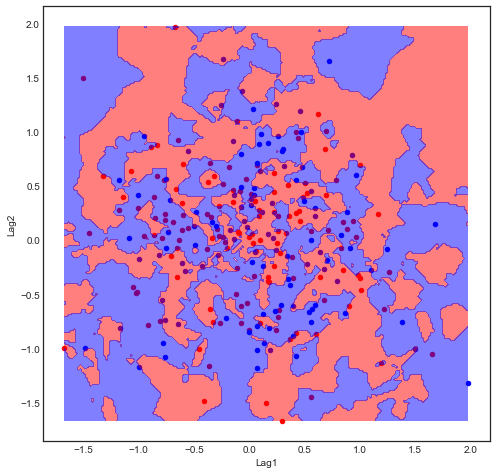

In [29]:
print_classification_statistics(knn, X_test2, y_test, labels=["Down", "Up"])
plot_ROC(knn, X_test2, y_test, label="KNN Train/Test, only Lag1 and Lag2")
plot_classification(knn, X_test2, y_test)

## 4.6.6 An Application to Caravan Insurance Data

### KNN

In [30]:
df_caravan = pd.read_csv("Data/Caravan.csv")
df_caravan["Purchase"] = df_caravan["Purchase"].astype("category")
df_caravan.head()

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No
2,3,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,No
3,4,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,No
4,5,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,No


In [31]:
df_caravan["Purchase"].value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [32]:
y = df_caravan.Purchase
X = df_caravan.drop("Purchase", axis=1).astype("float64")
X_scaled = preprocessing.scale(X)

In [33]:
X_test = X_scaled[:1000]
y_test = y[:1000]
X_train = X_scaled[1000:]
y_train = y[1000:]

In [34]:
for i in [1, 3, 5]:
    print(f"Using {i} neighbors")
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    print_classification_statistics(knn, X_test, y_test, labels=["No", "Yes"])
    # plot_ROC(knn, X_test, y_test, label='KNN')
    # skplt.metrics.plot_confusion_matrix(y_test, knn.predict(X_test), normalize=False)
    plt.show()

Using 1 neighbors
Classification Report:
             precision    recall  f1-score   support

         No      0.948     0.937     0.943       941
        Yes      0.157     0.186     0.171        59

avg / total      0.902     0.893     0.897      1000

Confusion Matrix:
           Predicted          
                True     False
Real True   0.937301  0.062699
     False  0.813559  0.186441

Using 3 neighbors
Classification Report:
             precision    recall  f1-score   support

         No      0.946     0.979     0.962       941
        Yes      0.231     0.102     0.141        59

avg / total      0.903     0.927     0.913      1000

Confusion Matrix:
           Predicted          
                True     False
Real True   0.978746  0.021254
     False  0.898305  0.101695

Using 5 neighbors
Classification Report:
             precision    recall  f1-score   support

         No      0.944     0.993     0.968       941
        Yes      0.364     0.068     0.114        59



### Logistic

In [35]:
logistic = skl_lm.LogisticRegression(C=1e10)
logistic.fit(X_train, y_train)
print_classification_statistics(logistic, X_test, y_test, labels=["No", "Yes"])

Classification Report:
             precision    recall  f1-score   support

         No      0.941     0.994     0.966       941
        Yes      0.000     0.000     0.000        59

avg / total      0.885     0.935     0.909      1000

Confusion Matrix:
           Predicted          
                True     False
Real True   0.993624  0.006376
     False  1.000000  0.000000



In [36]:
# using 25% changes of buying instead of 50%
pred_p = logistic.predict_proba(X_test)
cm_df = pd.DataFrame({"True": y_test, "Pred": pred_p[:, 1] > 0.25})
cm_df.Pred.replace(to_replace={True: "Yes", False: "No"}, inplace=True)
print(classification_report(y_test, cm_df.Pred))
print(cm_df.groupby(["True", "Pred"]).size().unstack("True").T)

             precision    recall  f1-score   support

         No       0.95      0.98      0.96       941
        Yes       0.34      0.19      0.24        59

avg / total       0.91      0.93      0.92      1000

Pred   No  Yes
True          
No    920   21
Yes    48   11
